In [1]:
__author__ = 'Robert Nikutta, Stéphanie Juneau, Knut Olsen & the NOAO Data Lab team <datalab@noao.edu>'
__version__ = '20170507' # yyymmdd

# Detecting the Hydra II dwarf galaxy &
# RR Lyrae time-series analysis

*Robert Nikutta, Stéphanie Juneau, Knut Olsen & the NOAO Data Lab team*

# Detecting the Hydra II dwarf galaxy

* [query the SMASH catalog in one field & filter for blue stars (expected in metal-poor dwarfs)](#query)
* [spatial density plot](#spatial)
* [detect overdensities (differential Gaussian kernels)](#kernel)
* [find peaks](#peaks)
* [visually inspect images (Simple Image Access)](#sia)
* [save your results to a local file](#savefile)
* [CM diagrams of all stars around the peaks](#cmdiagrams)

# RR Lyrae time-series analysis

* [get & plot the lightcurve](#getlightcurve)
* [compute Lomb-Scargle priodogram & find best period](#lombscargle)
* [phase the lightcurve and compute a simple model](#phase)

# Data retrieval
We will retrieve data from Field 169 of the SMASH catalog ([Nidever et al. (subm.)](http://adsabs.harvard.edu/abs/2017arXiv170100502N)) and look for overdensities of blue objects.

The required columns are RA, Dec, and the g, r, i magnitudes.

# Detection
We will convolve the spatial distribution of our dataset with a pair of Gaussian kernels and subtract the results, as done by e.g. [Koposov et al. (2008, ApJ, 686, 279)](http://adsabs.harvard.edu/abs/2008ApJ...686..279K). This has the effect of convolving the spatial distribution with a Mexican hat filter, which is useful for detecting objects at a desired spatial scale.

# Imports & initialization

In [2]:
# std lib
import sys
import warnings
warnings.filterwarnings('ignore')  # I know, I know...

# 3rd party
import numpy as np
from astropy import utils, io, convolution, stats

from photutils import find_peaks
import pylab as p
import matplotlib
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%matplotlib inline
from IPython.display import FileLink

# Data Lab
from dl import helpers

# plots default setup
fontsize = 14
p.rcParams['font.size'] =  fontsize
p.rcParams['axes.labelsize'] = fontsize
p.rcParams['axes.titlesize'] = fontsize
p.rcParams['legend.fontsize'] = fontsize-2
p.rcParams['xtick.labelsize'] = fontsize
p.rcParams['ytick.labelsize'] = fontsize
p.rcParams['figure.figsize'] = (7, 5.8)

# User query helper class
Use helper class `Querist` from the helpers module. It simply hides a lot of boilerplate that we don't want to worry about right now.

In [3]:
Q = helpers.Querist('anonymous')  # username, here 'anoanymous'

#### <font color='red'>_Once you're done working with a notebook, clear the authentication token by executing once:_</font>

``` python
Q.clearToken()
```

We will use the `Querist` instance to get some tables into RAM. Let's see what output formats are currently supported:

In [4]:
Q.output_formats

'outfmt' arg   Returned output
------------------------------
      string   CSV formatted table as a string
       array   Numpy array
 structarray   Numpy structured / record array
      pandas   Pandas dataframe
       table   Astropy Table
     votable   Astropy VOtable


<a class="anchor" id="query"></a>
# Query the SMASH DR1 database

We will query the averaged photometry table from the SMASH catalog and select field #169.  We will limit the query to avoid photometry taken only with short exposures (depthflag>1), avoid broad objects (|sharp|<0.5), and pick blue objects (-0.4 < g-r < 0.4).
## Construct the query string

In [5]:
field = 169 # SMASH field number to query
depth = 1   # depth (=no short exposures please)

# Create the query string; SQL keyword capitalized for clarity
query_template =\
"""SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
   WHERE fieldid = '%d' AND
         depthflag > %d AND
         abs(sharp) < 0.5 AND
         gmag BETWEEN 9 AND 25 AND
         (gmag-rmag) BETWEEN -0.4 AND 0.4"""

query = query_template % (field, depth)

# Submit the query
Running the query in synchroneous mode is very easy with the `Querist` helper.

In [6]:
# get result as a Pandas dataframe; and let's preview the first two rows
R = Q(query,outfmt='pandas',preview=2)
print "Number of objects found:", R.shape[0]

Returning Pandas dataframe
RESULT PREVIEW (2 rows)
ra,dec,gmag,rmag,imag
184.462612253906,-32.4152395239094,23.0753,22.8203,22.3014
184.465705798635,-32.4091410557569,24.4911,24.5583,24.4964
Number of objects found: 122720


<a class="anchor" id="spatial"></a>
# Make a figure of the spatial distribution

You might spot some overdensities already.

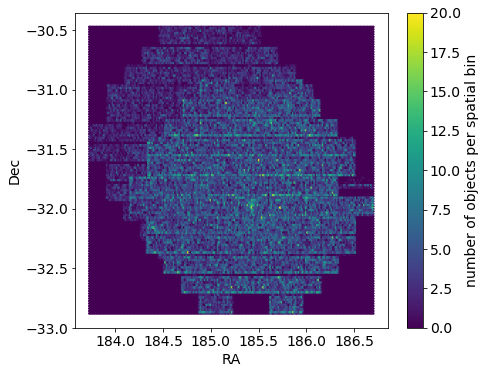

In [7]:
im = p.hexbin(R['ra'], R['dec'],gridsize=200)
p.xlabel('RA'); p.ylabel('Dec')
p.colorbar(label='number of objects per spatial bin');

<a class="anchor" id="kernel"></a>
# The Dwarf Filter
Here we define the dwarf filter as a differential convolution of a two-dimensional image using two Gaussian kernels; this has the effect of convolution with a Mexican hat filter.  The default kernel shapes look for objects on the scale of a few arcmin.  The output includes a clipped array of the convolved spatial distribution, which we will use for peak detection.

In [8]:
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    # Based on Koposov et al. (2008).
    # Code by Ken Mighell and Mike Fitzpatrick.
    # Minor edits by RN.
    
    x, y = ra, dec

    print "Computing differential convolution .... ",
    sys.stdout.flush()

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint (xdiff_angular_arcmin).astype('int')
    ny = np.rint (ydiff_arcmin).astype('int')

    print nx,ny
    
    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve (raw_hist, kernel_big)
    conv_small = convolution.convolve (raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean (delta, dtype='float64')
    sigma = np.std (delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median (delta)                       # not used
    floor = mean 

    print 'dwarf_filter: mean = %g  sigma = %g sigmaRaw = %g' % (mean, sigma, sigmaRaw)

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

# Run the dwarf filter
We'll use the default convolution kernels of 2 and 20 arcminutes in size.

In [9]:
small_k, big_k = 2., 20.
raw, extent, delta, clipped, dsigma = dwarf_filter(R['ra'],R['dec'],fwhm_small=small_k,fwhm_big=big_k)

Computing differential convolution ....  152 144
dwarf_filter: mean = 0.12983  sigma = 1.83688 sigmaRaw = 5.2888


# Plot the convolved 2D histogram

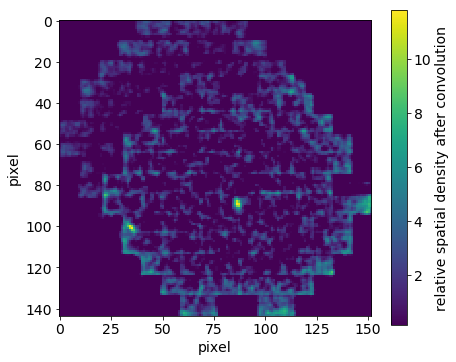

In [10]:
fig, ax = p.subplots()
im = p.imshow(clipped)
p.xlabel('pixel')
p.ylabel('pixel')
p.colorbar(label='relative spatial density after convolution');

<a class="anchor" id="peaks"></a>
# Identify peaks
We'll use the `photutils` package to identify 10-sigma peaks in the clipped filtered image.

In [11]:
# find peaks
mean, median, std = stats.sigma_clipped_stats(clipped,sigma=3.0,iters=5)    
tbl = find_peaks(clipped,median+10,box_size=small_k*2)
A = tbl.as_array()

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print tbl

x_peak y_peak   peak_value        ra           dec      
------ ------ ------------- ------------- --------------
    86     89 11.7455211757 185.409637194 -31.9767210502
    35    101 11.8026190195 184.411404572 -32.1771980615


# Show the identified density peaks

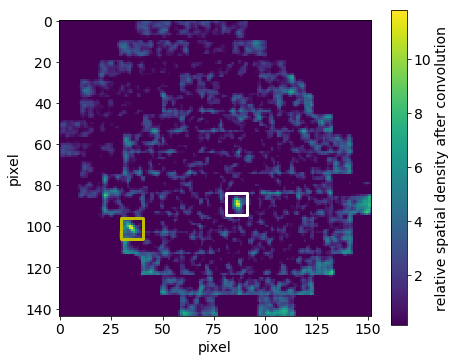

In [12]:
ecs = ['w','y']
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

<a class="anchor" id="sia"></a>
# Inspect the image cutouts around the peaks
# (Simple Image Access service)
Data Lab comes with batteries included. An image cutout and download service are built in.

In [13]:
# set up SIA
from pyvo.dal import sia
#DEF_ACCESS_URL = "http://datalab.noao.edu/sia/smash"
DEF_ACCESS_URL = "http://zeus1.sdm.noao.edu/siapv1"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print "The full image list contains", len(imgTable), "entries"
    
    sel0 = (imgTable['proctype']=='Stacked') & (imgTable['prodtype']=='image') # basic selection
    images = []
    for band in bands:
        print "Band %s:" % band,
        sel = sel0 & (imgTable['obs_bandpass']==band) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print 'downloading deepest stacked image...'
        img = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))
        images.append(img)
        
    print "Downloaded %d images." % len(images)
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = p.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.PowerNorm(0.2,vmin=1.01*img.min(),vmax=0.3*img.max()))
        ax.set_title('%s band' % bands[j])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Get images for the "left yellow" box

In [14]:
bands = list('gri')
images = download_deepest_images(tbl['ra'][1], tbl['dec'][1], fov=0.07, bands=bands) # FOV in deg

The full image list contains 2514 entries
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


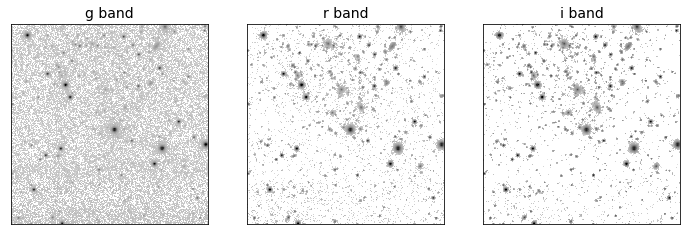

In [15]:
plot_images(images,bands=bands)

**Looks like a galaxy cluster!**

# Now the "white center box" object

The full image list contains 2718 entries
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


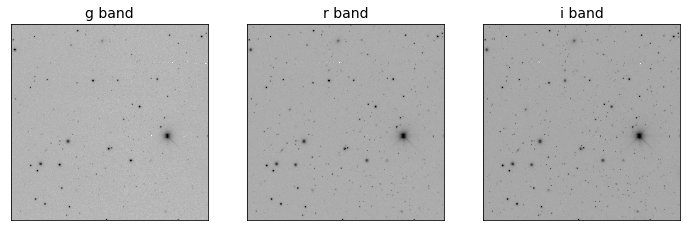

In [16]:
images = download_deepest_images(tbl['ra'][0], tbl['dec'][0])
plot_images(images)

**Doesn't look like much... but there's a dwarf galaxy in there!**

<a class="anchor" id="cmdiagrams"></a>
# Query the database for stars near peaks
Get photometry of stars within a 5 arcmin radius of each density peak.

A little helper function (**"Thou shalt never repeat thyself in thy code"**)

In [17]:
def makequery(ra0,dec0,radius0=5./60.,field=169,depth=1):
    query =\
    """SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
       WHERE fieldid = '%d' AND
           depthflag > %d AND
           abs(sharp) < 0.5 AND
           gmag BETWEEN 9 AND 25 AND
           q3c_radial_query(ra,dec,%s,%s,%s)
    """ % (field, depth,ra0,dec0,radius0)
    
    return query

In [18]:
query1 = makequery(tbl['ra'][0],tbl['dec'][0]) # center ra & dec
R1 = Q(query1,outfmt='pandas')
print len(R1), "objects found."

Returning Pandas dataframe
2333 objects found.


# Compute color columns

In [19]:
R1['g_r'] = R1['gmag'] - R1['rmag']
R1['g_i'] = R1['gmag'] - R1['imag']
R1.tail()

,ra,dec,gmag,rmag,imag,g_r,g_i
2328,185.474249,-31.920428,24.4443,24.1614,24.0371,0.2829,0.4072
2329,185.478490,-31.921857,24.7771,24.4996,24.3937,0.2775,0.3834
2330,185.475582,-31.918164,24.6640,24.9536,24.7214,-0.2896,-0.0574
2331,185.472299,-31.916688,24.4480,24.6672,24.7170,-0.2192,-0.2690
2332,185.468940,-31.910392,24.9769,24.4817,24.2284,0.4952,0.7485


# Now the other peak

In [20]:
query2 = makequery(tbl['ra'][1],tbl['dec'][1])
R2 = Q(query2,outfmt='pandas')
print len(R2), "objects found."

# compute colors
R2['g_r'] = R2['gmag'] - R2['rmag']
R2['g_i'] = R2['gmag'] - R2['imag']

Returning Pandas dataframe
2234 objects found.


# Color-magnitude diagrams of the peaks

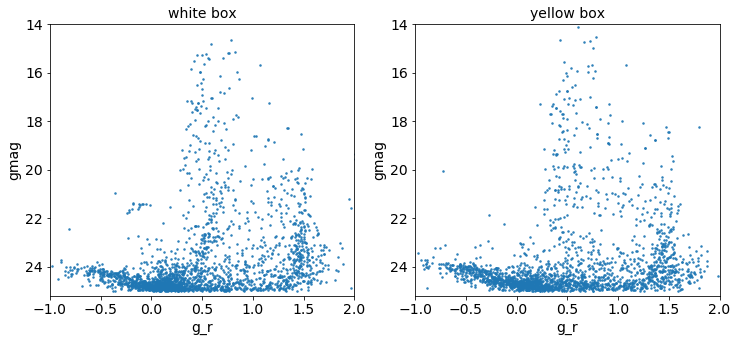

In [21]:
def plotpanel(axid,x,y,title='',xlim=(-1,2),ylim=(25.2,14)):
    ax = fig.add_subplot(axid)
    ax.scatter(x,y,marker='.',s=10, alpha=0.8)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
fig = p.figure(figsize=(12,5))
plotpanel(121,R1['g_r'],R1['gmag'],'white box')
plotpanel(122,R2['g_r'],R2['gmag'],'yellow box')

# Compare w/ Vivas+2016
![title](Vivas2016fig9.png)

<a class="anchor" id="savefile"></a>
# Save your results to a local file, take it with you if you like

Field 1 looks like a dwarf galaxy, i.e. an isolated overdensity. It is, in fact the Hydra II Dwarf Galaxy, first discovered and reported in [Martin et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...804L...5M)


Field 2 is a galaxy cluster (not what we're looking for here).

Let's save the photometry of all sources around the location of the dwarf galaxy (i.e. the objects we used to create the CMD) to a local file. Take it with you if you like.

In [22]:
# save the photometry of Field 1 to a CSV local file
R1.to_csv('hydra_II_photometry.csv',index=False) # save to local file

# print the first few lines of that file (using ! as a system call from this notebook)
!head -10 hydra_II_photometry.csv

# make a nice download link here
print "\nClick to download:"
FileLink('hydra_II_photometry.csv')

ra,dec,gmag,rmag,imag,g_r,g_i
185.354949125,-32.0454253882,22.6198,21.1424,20.2578,1.4774,2.362
185.341390444,-32.0346101196,18.7621,17.6098,17.1748,1.1523,1.5873
185.340696479,-32.0339466127,24.6669,,,,
185.352839953,-32.0389772123,24.8141,24.3438,23.9558,0.4703,0.8583
185.350617028,-32.0355923528,24.5538,23.8475,23.4574,0.7063,1.0964
185.350116818,-32.0336947616,24.8034,23.6624,23.1638,1.141,1.6396
185.355643174,-32.0334330489,24.2311,23.4712,23.1542,0.7599,1.0769
185.324628934,-32.0182019803,17.4724,16.8114,16.5808,0.661,0.8916
185.340682491,-32.0307249966,24.4978,24.308,23.8732,0.1898,0.6246

Click to download:


/net/dl1/users/robert/notebooks/hydra_II_photometry.csv

<a class="anchor" id="getlightcurve"></a>
# Time-series analysis of a RR Lyrae star in Hydra II
Let's study the variability of an astrophysical object. In the Hydra II dwarf galaxy, one object is highly variable; it is a RR Lyrae star. We'll get the measurements for it from the SMASH survey's `source` table.

# Get lightcurves of one object
We can retrieve all calibrated magnitudes of a specific object, for all bands, and all epochs, from the `source` table.

In [23]:
objID = '169.429960' # this happens to be a RR Lyrae star in Hydra II
# select columns modified Julian date, calibrated mag, filter
# note: the DB encodes 'no measurement' values as 99.99
query = "SELECT ra,dec,mjd,cmag,cerr,filter FROM smash_dr1.source WHERE id='%s' AND cmag<99 ORDER BY mjd ASC" % objID

df = Q(query,outfmt='pandas',preview=2)

Returning Pandas dataframe
RESULT PREVIEW (2 rows)
ra,dec,mjd,cmag,cerr,filter
185.431155383634,-31.9953268802986,56371.3275383739,21.4331,0.0206513,g
185.431146196886,-31.9953236127704,56371.3285625321,21.2316,0.0224732,r


# Plot light-curves per-band
Plot the light-curves of this source separately for every band. We also zoom in on a range of dates with interesting measurements.

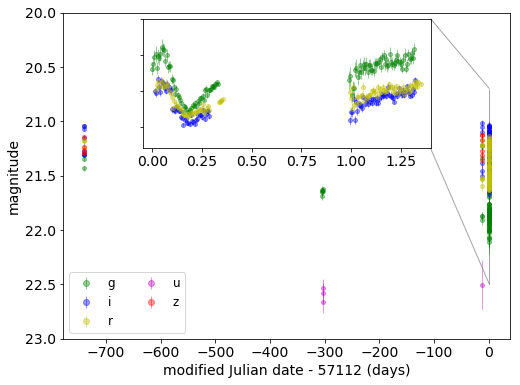

In [24]:
fig, ax = p.subplots(figsize=[8, 6]) # main panel
axins = inset_axes(ax, 4, 1.8, loc=9) # inset
filters = np.unique(df['filter'])
colors = dict(zip(filters,('g','b','y','m','r'))) # plotting colors
jd0 = 57112
start = 16 # in the inset we'll zoom in on some data
for filt in filters:
    sel = (df['filter'] == filt) # select one filter
    t = df['mjd'][sel].values
    y = df['cmag'][sel].values
    dy = df['cerr'][sel].values
    c = colors[filt]
    ax.errorbar(t-jd0,y,yerr=dy,marker='.',ms=8,ls='none',lw=1,color=c,alpha=0.4,label=filt)
    axins.errorbar(t[start:]-jd0,y[start:],yerr=dy[start:],marker='.',ms=8,ls='none',lw=1,color=c,alpha=0.4,label=filt)

# Main panel chores
ax.set_xlabel('modified Julian date - %d (days)' % jd0)
ax.set_ylabel('magnitude')
ax.set_ylim(23,20)
ax.legend(loc='lower left',frameon=True,ncol=2,markerscale=1.5)

# Inset magic
axins.yaxis.set_major_formatter(NullFormatter())
x1, x2, y1, y2 = -0.05, 1.4, 22.5, 20.7 # sub region of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y2, y1)

# draw bbox around inset; connect with parent axes
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5",lw=1,alpha=0.7);

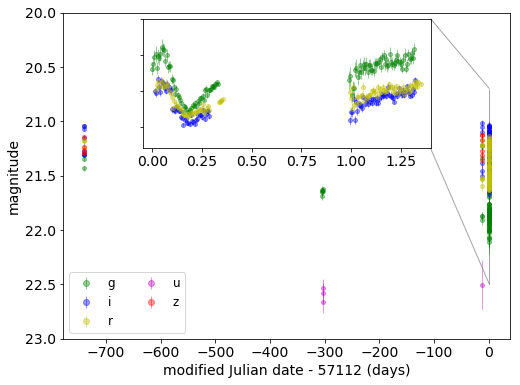

In [25]:
fig

<a class="anchor" id="lombscargle"></a>
# Find periodicity
One of many methods for finding the period of a variable is the Lomb-Scargle periodogram. It works in the Fourier domain. We'll apply it here to all g band measurements of our RR Lyrae star.

In [26]:
filt = 'g'
sel = (df['filter'] == filt)
t = df['mjd'][sel].values
y = df['cmag'][sel].values
dy = df['cerr'][sel].values

ls = stats.LombScargle(t, y)
# min freq = 1/longest expected period (in days)
# max freq = 1/shortest expected perdiod (in days)
# RR Lyrae usually have a period of a fraction of one day
frequency, power = ls.autopower(minimum_frequency=1./1.,maximum_frequency=1./0.1)

period = 1./frequency # period is the inverse of frequency
best_period = 1./frequency[np.argmax(power)]  # period with most power / strongest signal

# Plot periodogram (or "variogram")

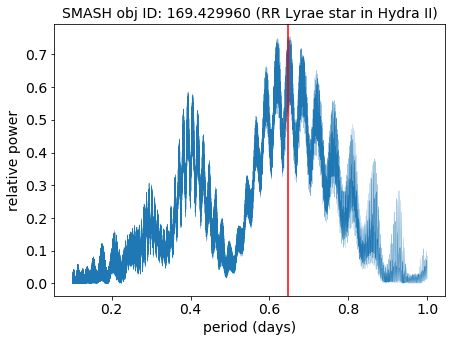

In [27]:
fig = p.figure(figsize=(7,5))
p.plot(period,power,lw=0.2)
p.xlabel('period (days)')
p.ylabel('relative power')
p.title('SMASH obj ID: 169.429960 (RR Lyrae star in Hydra II)')
p.axvline(best_period,color='r');

Best period: 0.648145563431 days


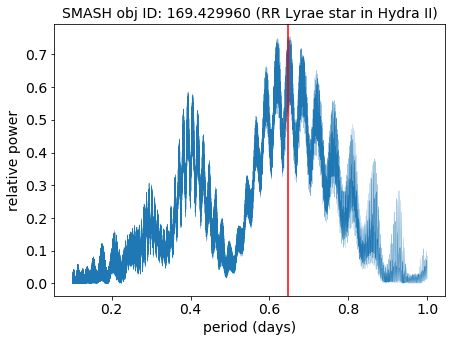

In [28]:
print "Best period:", best_period, "days"
fig

[Vivas et al. 2016](http://adsabs.harvard.edu/abs/2016AJ....151..118V) found with a (complementary!) phase dispersion minimization technique a period of 0.645 days. **We're in excellent agreement :-)**

<a class="anchor" id="phase"></a>
# Phase the entire lightcurve and plot it

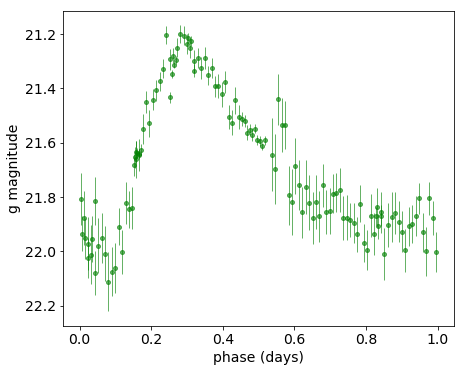

In [29]:
# light curve over period, take the remainder (i.e. the "phase" of one period)
phase = (t / best_period) % 1
fig, ax = p.subplots()
ax.errorbar(phase,y,yerr=dy,marker='.',ms=8,ls='none',lw=1,color='g',alpha=0.6)
ax.invert_yaxis()
ax.set_xlabel('phase (days)')
ax.set_ylabel('%s magnitude' % filt);

# Compute the Lomb-Scargle model

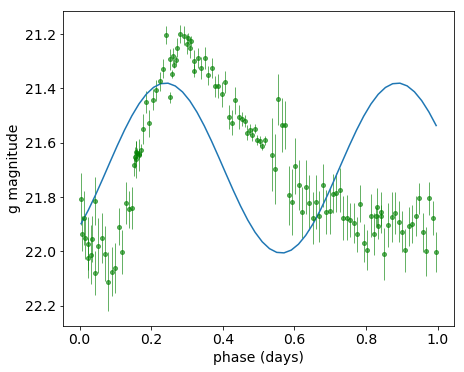

In [30]:
t_fit = np.linspace(phase.min(), phase.max())
y_fit = stats.LombScargle(t, y).model(t_fit, 1./best_period)
ax.plot(t_fit,y_fit) # keeps writing to current figure
fig  # repeats the (possibly updated) figure

**A simple sinusoid is not a good model for RR Lyrae pulsations!!** --> Hack idea: fit more realistic models, e.g. via RR Lyrae templates.

# Some resources


Nidever et al. (submitted) "SMASH - Survey of the MAgellanic Stellar History": http://adsabs.harvard.edu/abs/2017arXiv170100502N

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K

Martin et al. (2015, ApJ, 804, 5) "Hydra II: A Faint and Compact Milky Way Dwarf Galaxy Found in the Survey of the Magellanic Stellar History": http://adsabs.harvard.edu/abs/2015ApJ...804L...5M

Vivas et al. 2016 (2016, AJ, 151, 118) "Variable Stars in the Field of the Hydra II Ultra-Faint Dwarf Galaxy": http://adsabs.harvard.edu/abs/2016AJ....151..118V

Jake VanderPlas' blog on Lomb-Scargle periodograms and on fitting RR Lyrae lightcurves with templates: https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

Lomb-Scargle periodograms in `astropy`: http://docs.astropy.org/en/stable/stats/lombscargle.html

RR Lyrae variables on wikipedia: https://en.wikipedia.org/wiki/RR_Lyrae_variable

# Hack ideas

* Find overdensities elsewhere; optimize

* Fit more physical RR Lyrae models, e.g. via templates

* Find "all" variable objects in DECaLS or SMASH and classify them (ML, random forest, ...)